In [1]:
# import some modules
import time
import numpy as np
import wfdb
import ast
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
from scipy.fftpack import fft, ifft 
from scipy import signal

In [3]:
#Path Definition

path = 'h:\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1\\'
sampling_rate = 500


In [4]:
# read label file and transfer it
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [5]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [6]:
X = load_raw_data(Y, sampling_rate, path)


In [7]:
# get diagnose information
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)

In [8]:
agg_df = agg_df[agg_df.diagnostic == 1]


In [9]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [10]:
# add diagnose information
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [11]:
Y.columns


Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass'],
      dtype='object')

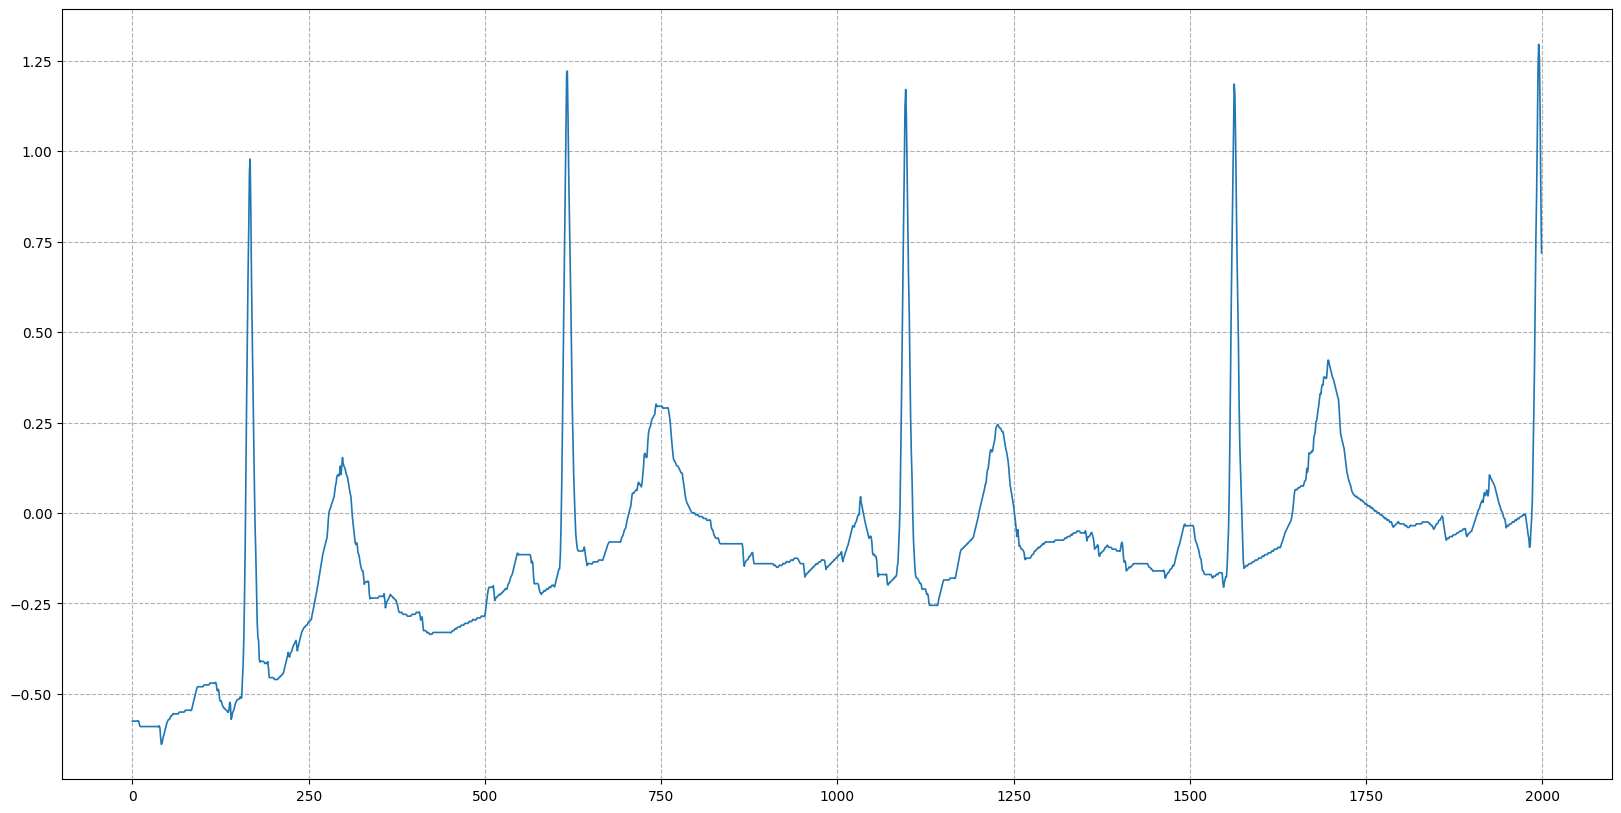

In [12]:
# check the ecg waves in lead II
plt.rcParams['figure.figsize'] = (20.0, 10.0) 
plt.figure()
plt.plot(X[4][:2000,1], linewidth=1.2)
plt.grid(linestyle='--')
# plt.yticks([])
plt.show()

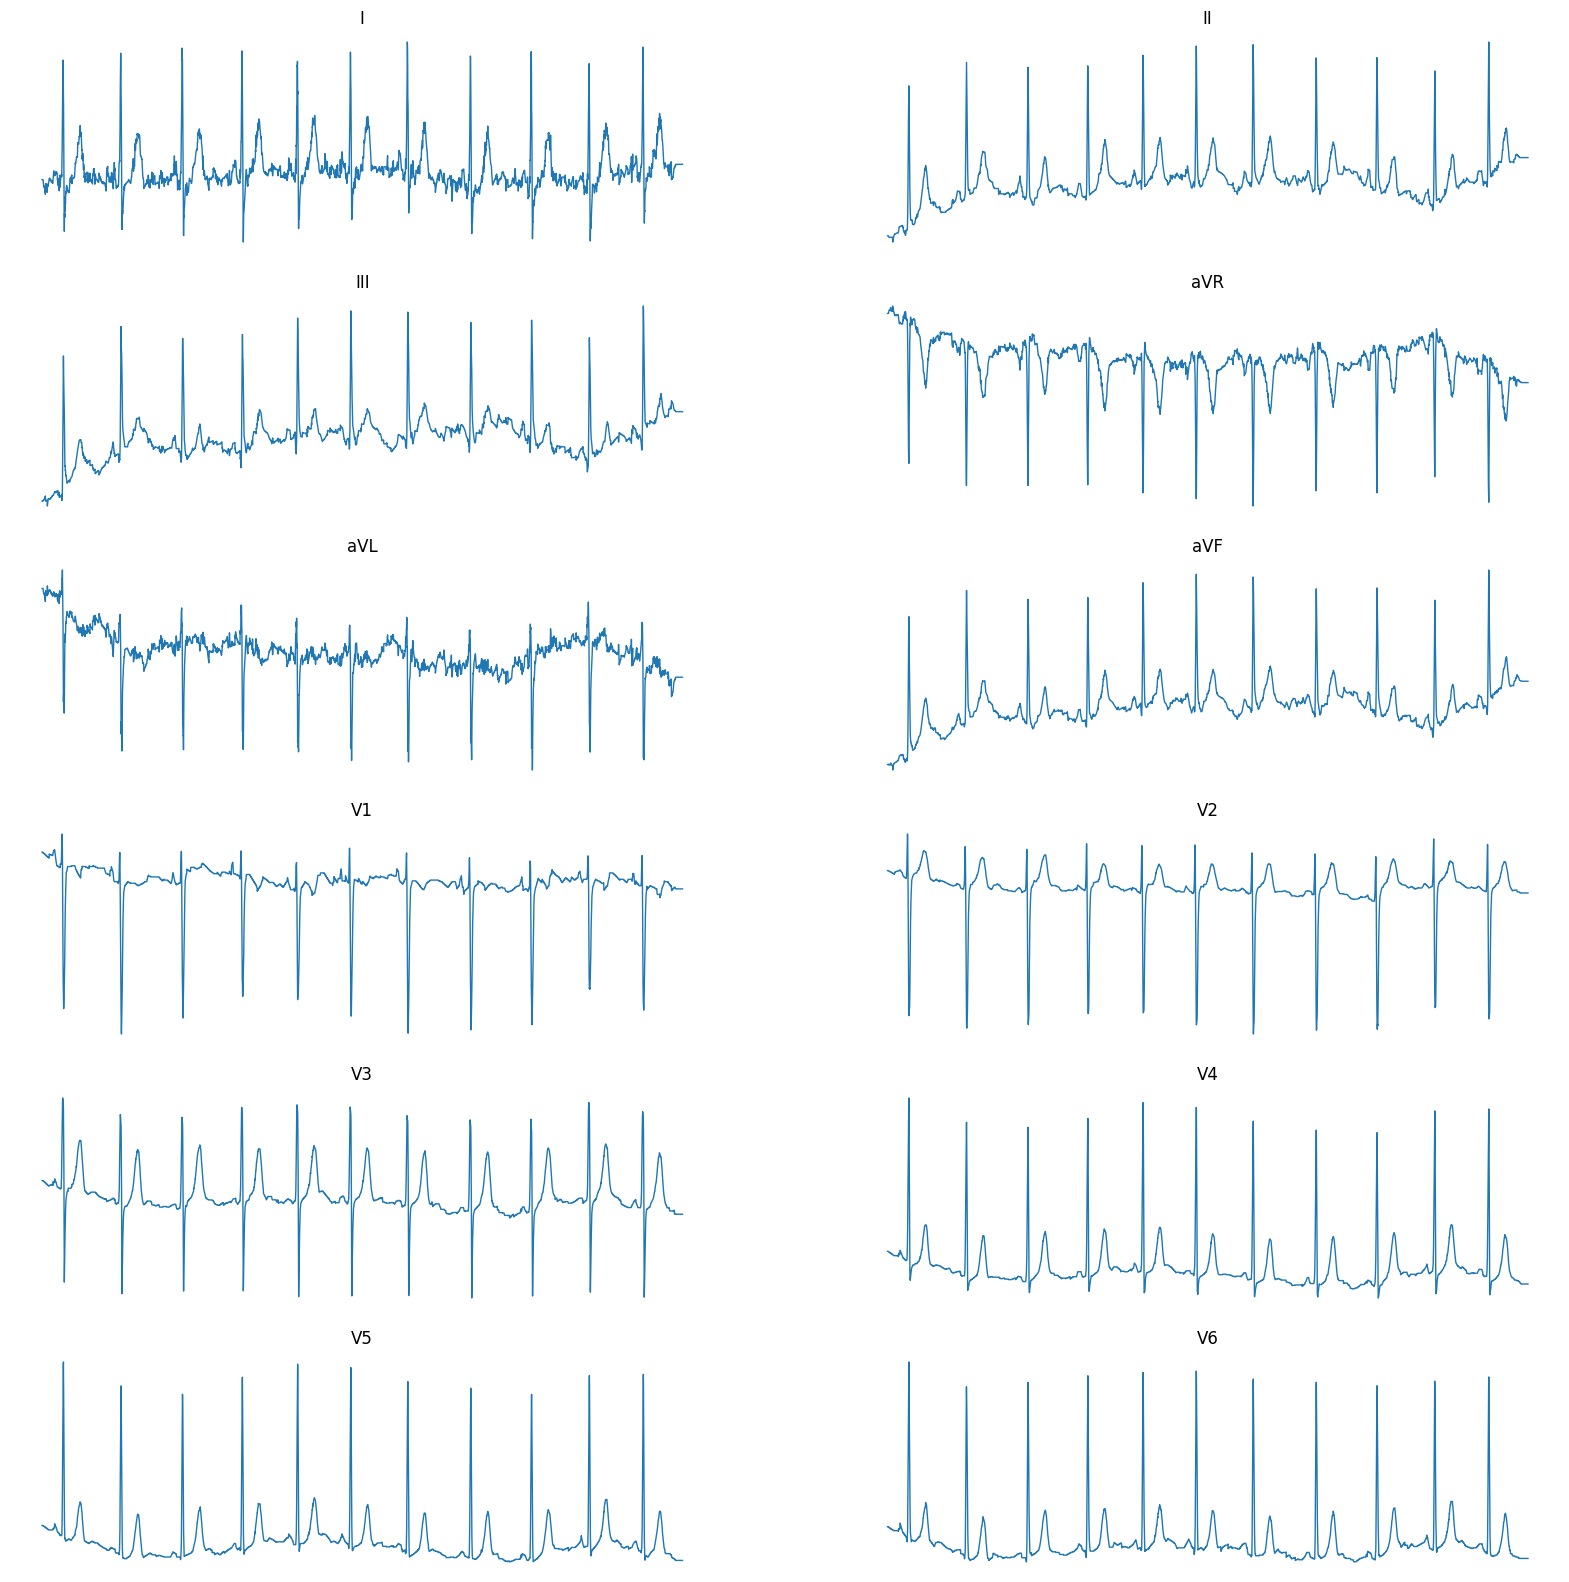

In [13]:
# check all 12 lead ecg data
ecg = X[4]
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (0.1,0.1)
plt.figure()
for index in range(12):
    plt.subplot(6,2,index+1)
    plt.plot(ecg[:,index], linewidth=1)
    
    # plt.yticks(np.arange(np.min(ecg[:,index]), np.max(ecg[:,index]), 0.1))
    plt.gca()
    plt.title(titles[index])
    plt.axis('off')

plt.show()

In [14]:
# fft function
def ecg_fft_ana(ecg_original, sampling_rate):
    fs = sampling_rate
    ts = 1.0/fs
    t = np.arange(0, 1, ts)
    n = len(ecg_original)
    k = np.arange(n)
    t = n/fs
    frq = k/t
    frq = frq[range(int(n/2))]
    fft_ecg = np.abs(fft(ecg_original))[range(int(n/2))]
    return frq, fft_ecg

In [15]:
# show fft difference of two signals
def show_spec_dif(ecg_original, ecg_filtered, title1="title1", title2 = "title2"):
    frq, fft_ecg = ecg_fft_ana(ecg_original, sampling_rate)
    frq_filtered, fft_ecg_filtered = ecg_fft_ana(ecg_filtered, sampling_rate)
    plt.rcParams['figure.figsize'] = (20.0, 10.0) 
    plt.figure()
    plt.subplot(221)
    plt.plot(ecg_original[:1500])
    plt.title(title1)
    plt.subplot(222)
    plt.plot(frq,fft_ecg)
    plt.title(title1 + '`s spectrum')
    plt.subplot(223)
    plt.plot(ecg_filtered[:1500])
    plt.title(title2)
    plt.subplot(224)
    plt.plot(frq_filtered, fft_ecg_filtered)
    plt.title(title2 + '`s spectrum')
    plt.show()

In [16]:
ecg_original = X[10,:,0]
ecg_original2 = X[1000,:,0]

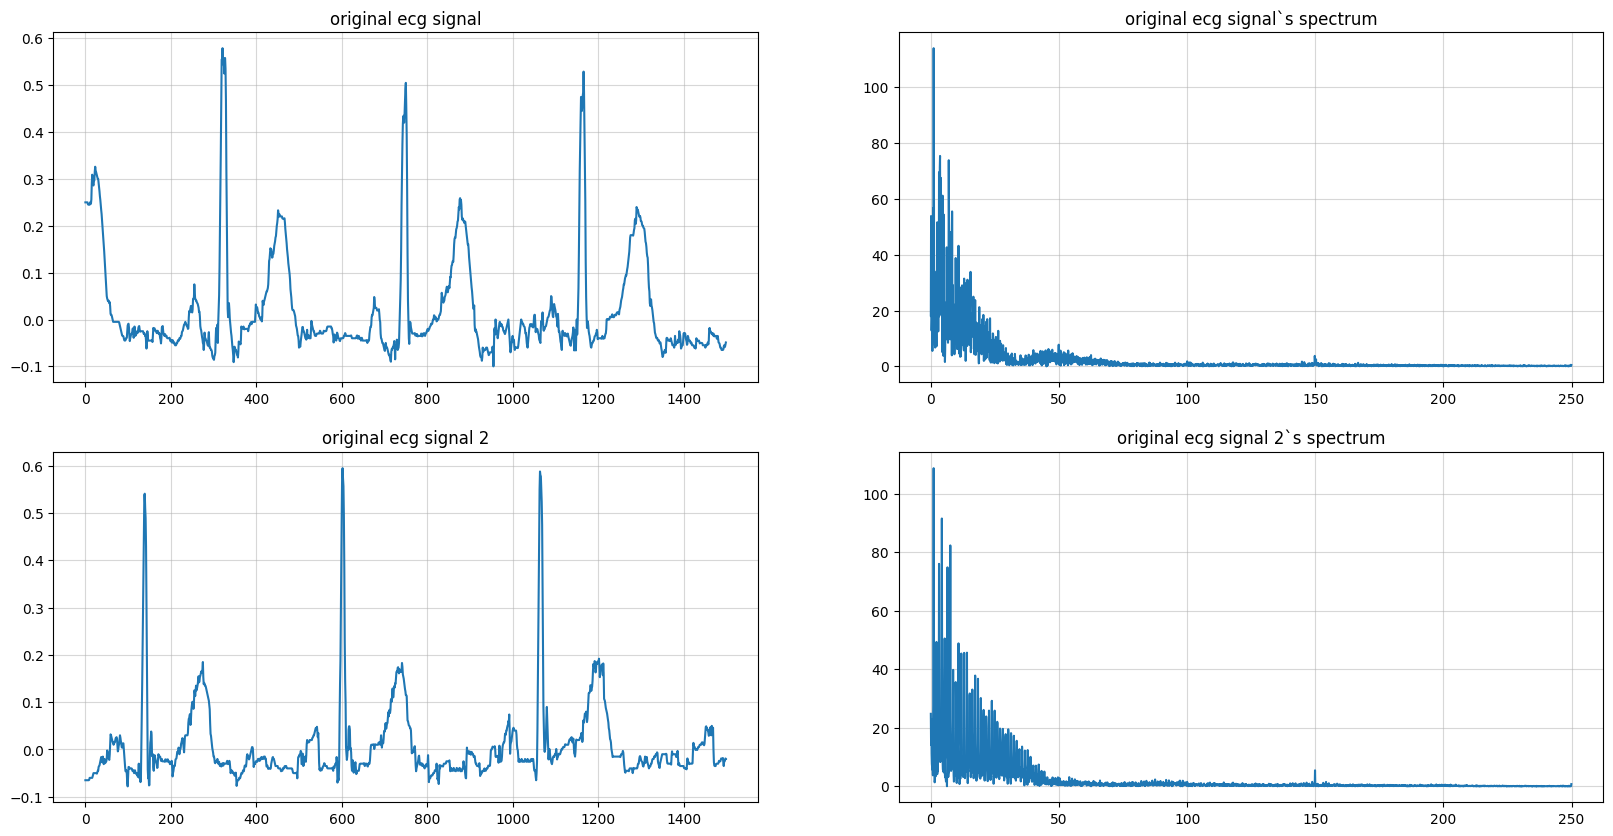

In [17]:
show_spec_dif(ecg_original, ecg_original2, 'original ecg signal', 'original ecg signal 2')


In [18]:
# n points window filtering
def np_move_avg(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))

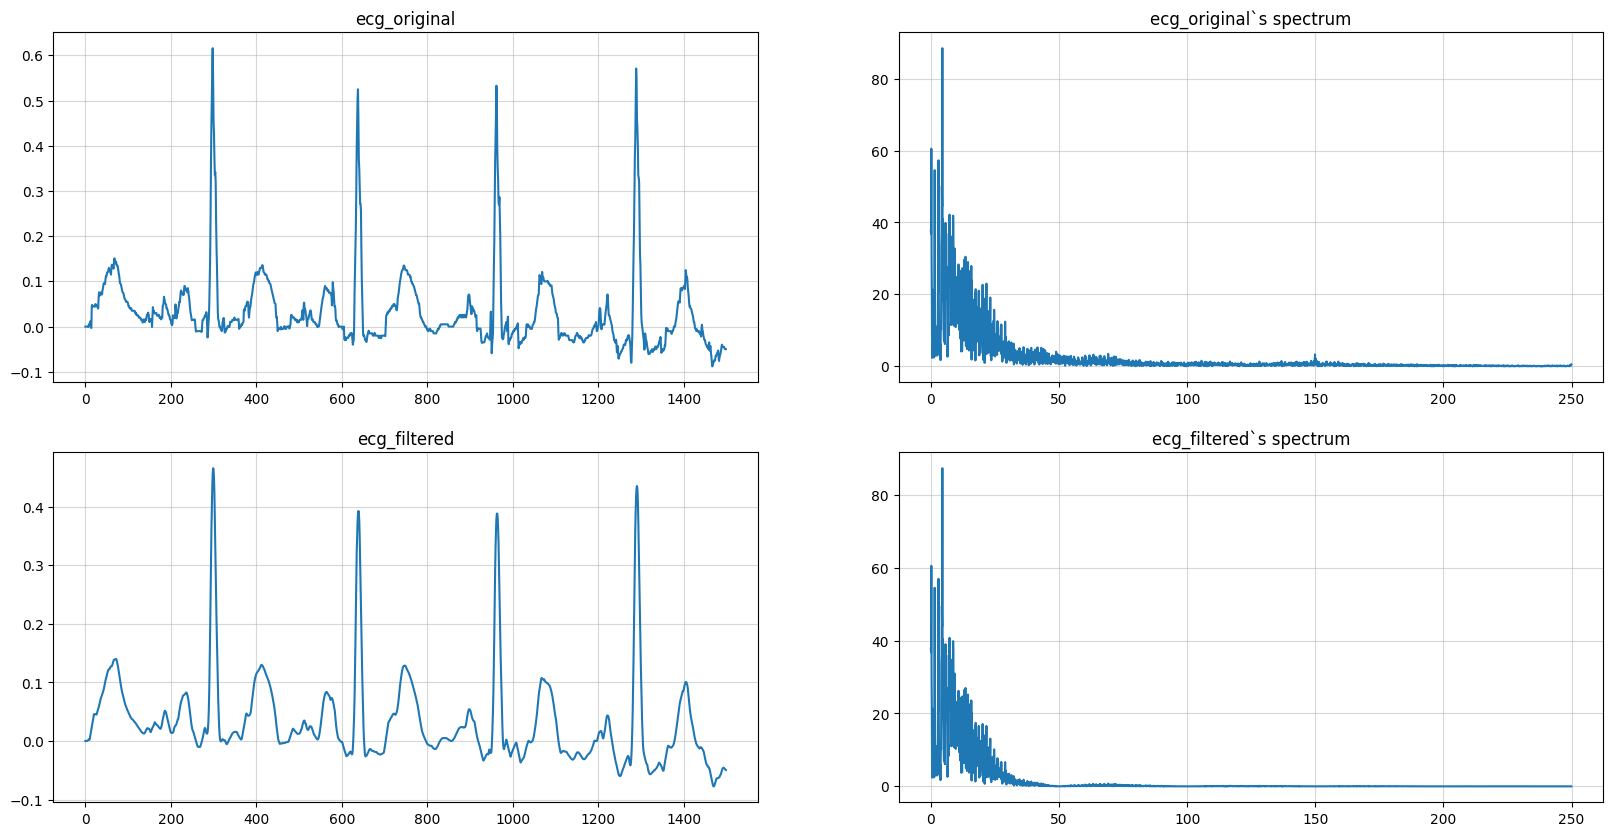

In [19]:
# ecg_original = X[np.random.randint(X.shape[0]),:,1]
ecg_original = X[248,:,0]

ecg_filtered = np_move_avg(ecg_original, 10)
show_spec_dif(ecg_original, ecg_filtered, "ecg_original", "ecg_filtered")

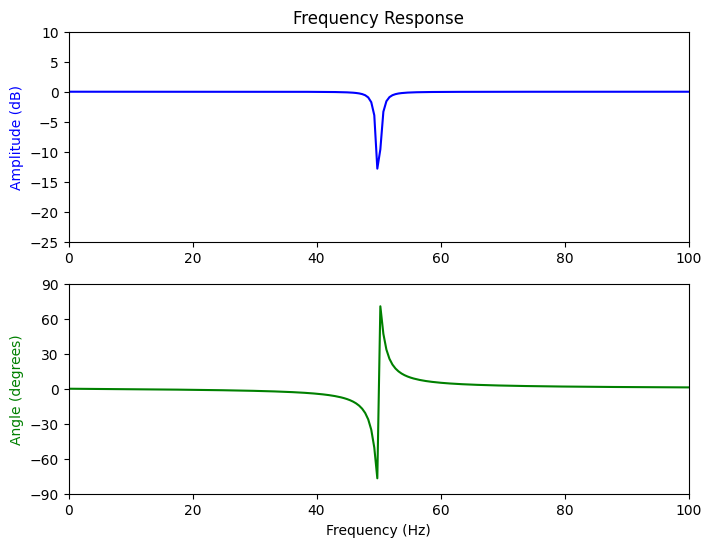

In [20]:
fs = sampling_rate  
f0 = 50.0   # nosie frequency to remove
Q = 30.0    # quality factor
b, a = signal.iirnotch(f0, Q, fs)
freq, h = signal.freqz(b, a, fs=fs)
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([-25, 10])
ax[0].grid()
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid()
plt.show()

In [21]:
# filter power noise 50Hz
ecg_notch = signal.filtfilt(b, a, ecg_filtered) 

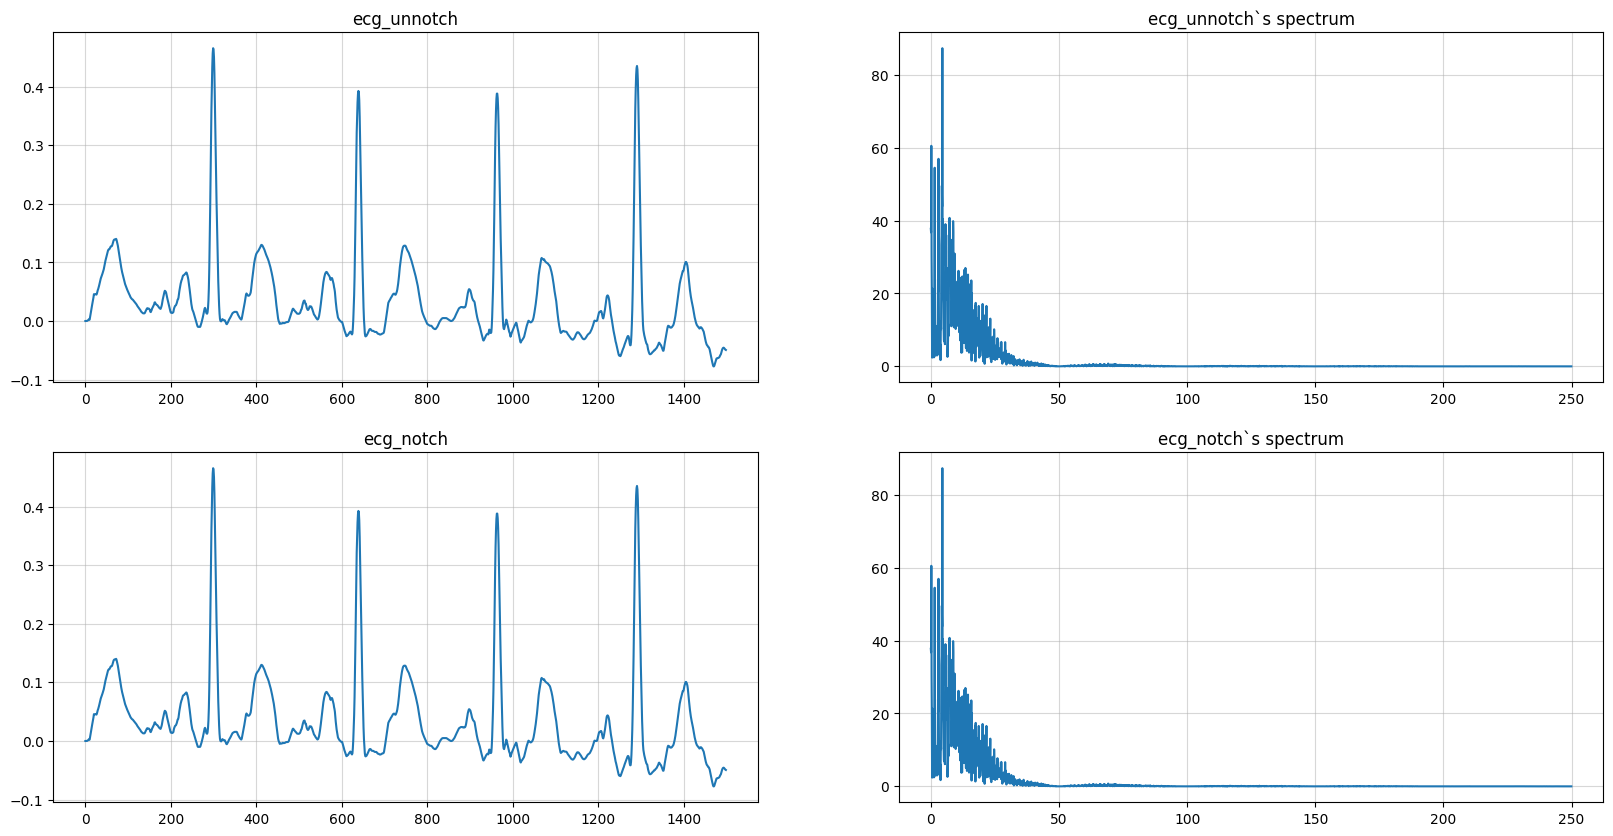

In [22]:
show_spec_dif(ecg_filtered, ecg_notch, "ecg_unnotch", "ecg_notch")


In [23]:
# filter noise in all leads
channels = 12
X_filtered = np.ones_like(X)
for index in range(len(X)):
    if index % 1000 == 0:
        print("---index %d finished filtered, process : %d %%---" % (index, index/X.shape[0]*100)) 
    for channel in range(channels):
        X_filtered[index][:, channel] = np_move_avg(X[index][:, channel], 5)
print("---all files finished filtering, process 100% !---")

---index 0 finished filtered, process : 0 %---
---index 1000 finished filtered, process : 4 %---
---index 2000 finished filtered, process : 9 %---
---index 3000 finished filtered, process : 13 %---
---index 4000 finished filtered, process : 18 %---
---index 5000 finished filtered, process : 22 %---
---index 6000 finished filtered, process : 27 %---
---index 7000 finished filtered, process : 32 %---
---index 8000 finished filtered, process : 36 %---
---index 9000 finished filtered, process : 41 %---
---index 10000 finished filtered, process : 45 %---
---index 11000 finished filtered, process : 50 %---
---index 12000 finished filtered, process : 54 %---
---index 13000 finished filtered, process : 59 %---
---index 14000 finished filtered, process : 64 %---
---index 15000 finished filtered, process : 68 %---
---index 16000 finished filtered, process : 73 %---
---index 17000 finished filtered, process : 77 %---
---index 18000 finished filtered, process : 82 %---
---index 19000 finished filt

In [24]:
# Split data into train and test
test_fold = 10
# Train
X_train = X_filtered[(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X_filtered[(Y.strat_fold == test_fold)]
y_test = Y[(Y.strat_fold == test_fold)].diagnostic_superclass

In [25]:
save_path = 'h:\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1\\'
np.save(save_path+'X_train1.npy', X_train)
np.save(save_path+'y_train1.npy', y_train)
np.save(save_path+'X_test1.npy', X_test)
np.save(save_path+'y_test1.npy', y_test)